In [ ]:
# Module for ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# install pyspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=81e2f7813571d5be551d47e590afe1f6d148b709f517d15a92751746d17cbaf7
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
# connect to google drive for dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install findspark
!pip install -q findspark

In [ ]:
# import sparksession module
import findspark
findspark.init()
from pyspark.sql import SparkSession
# create sparksession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# import libraries for common operations and plots
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

# import modules for data preprocessing, modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [ ]:
#sparkdf_train = spark.read.format("com.dtabricks.spark.csv").option("delimiter",",").option("multiline", "true").option("mode", "DROPMALFORMED").option("header", True).option("inferschema", True).csv("/content/drive/MyDrive/BD_Project/train.csv")
#sparkdf_test = spark.read.format("com.dtabricks.spark.csv").option("delimiter",",").option("multiline", "true").option("mode", "DROPMALFORMED").option("header", True).option("inferschema", True).csv("/content/drive/MyDrive/BD_Project/test.csv")
#sparkdf = spark.read.format("com.dtabricks.spark.csv").option("delimiter",",").option("multiline", "true").option("mode", "DROPMALFORMED").option("header", True).option("inferschema", True).csv("/content/drive/MyDrive/BD_Project/all_data_new.csv")

In [ ]:
# load the training dataset
train_data = pd.read_csv('/content/drive/MyDrive/BD_Project/train.csv')
traincount = train_data.count() 
print(f"Total training record {traincount}")

Total training record id                                     1804874
target                                 1804874
comment_text                           1804874
severe_toxicity                        1804874
obscene                                1804874
identity_attack                        1804874
insult                                 1804874
threat                                 1804874
asian                                   405130
atheist                                 405130
bisexual                                405130
black                                   405130
buddhist                                405130
christian                               405130
female                                  405130
heterosexual                            405130
hindu                                   405130
homosexual_gay_or_lesbian               405130
intellectual_or_learning_disability     405130
jewish                                  405130
latino                                

In [ ]:
# load testing dataset
test_data = pd.read_csv('/content/drive/MyDrive/BD_Project/test.csv')
testcount = test_data.count() 
print(f"Total Testing record {testcount}")

Total Testing record id              97320
comment_text    97320
dtype: int64


In [ ]:
# visualize few data present in train data 
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
# visualize few data present in test data
test_data.head()

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [ ]:
# visualize some basic statstics about data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1804874.0,3.738434e+06,2.445187e+06,59848.0,796975.25,5223774.5,5.769854e+06,6334010.00
target,1804874.0,1.030173e-01,1.970757e-01,0.0,0.00,0.0,1.666667e-01,1.00
severe_toxicity,1804874.0,4.582099e-03,2.286128e-02,0.0,0.00,0.0,0.000000e+00,1.00
obscene,1804874.0,1.387721e-02,6.460419e-02,0.0,0.00,0.0,0.000000e+00,1.00
identity_attack,1804874.0,2.263571e-02,7.873156e-02,0.0,0.00,0.0,0.000000e+00,1.00
insult,1804874.0,8.115273e-02,1.760657e-01,0.0,0.00,0.0,9.090909e-02,1.00
threat,1804874.0,9.311271e-03,4.942218e-02,0.0,0.00,0.0,0.000000e+00,1.00
asian,405130.0,1.196355e-02,8.716616e-02,0.0,0.00,0.0,0.000000e+00,1.00
atheist,405130.0,3.205019e-03,5.019273e-02,0.0,0.00,0.0,0.000000e+00,1.00
bisexual,405130.0,1.884285e-03,2.607737e-02,0.0,0.00,0.0,0.000000e+00,1.00


In [ ]:
# check if there are null values in train data
train_data.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [ ]:
# check if there are null values in test data
test_data.isnull().sum()

id              0
comment_text    0
dtype: int64

##Data Preprocessing

### Handling missing values

In [ ]:
# drop null values present and check again
train_data.dropna(axis=1, inplace=True)
train_data.isnull().sum()

id                          0
target                      0
comment_text                0
severe_toxicity             0
obscene                     0
identity_attack             0
insult                      0
threat                      0
created_date                0
publication_id              0
article_id                  0
rating                      0
funny                       0
wow                         0
sad                         0
likes                       0
disagree                    0
sexual_explicit             0
identity_annotator_count    0
toxicity_annotator_count    0
dtype: int64

### TF - IDF Vectorization

In [ ]:
# Vectorize input comments using TF-IDF vectorization
Vctrz = TfidfVectorizer()
Input_train = Vctrz.fit_transform(train_data["comment_text"])
Input_test = Vctrz.transform(test_data["comment_text"])
# convert labels into binary(0/1) as below for classification
Output_train = np.where(train_data['target'] >= 0.5, 1, 0)

### Splitting Data

In [ ]:
# split the data into training and testing data
Input_train, Input_test, Output_train, Output_test = train_test_split(Input_train, Output_train, test_size=1/3, random_state=42)

## Exploratory Data Analysis

### WordCloud Plots

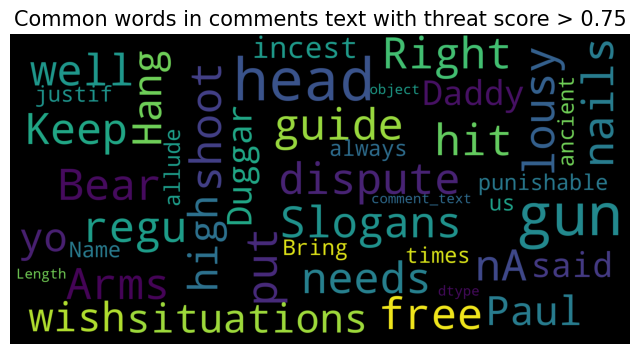

In [ ]:
# create word cloud of common words in comments with threat score >0.75 
w_cld = WordCloud(
        stopwords=stopwords,
        max_words=55,
        max_font_size=38, 
        scale=5,
        random_state=1
    ).generate(str(train_data.loc[train_data['threat'] > 0.75]['comment_text']))

# plot the wordcloud
fig = plt.figure(1, figsize=(8,8))
plt.axis('off')
plt.title(label = 'Common words in comments text with threat score > 0.75', fontsize=15)
fig.subplots_adjust(top=2.3)
plt.imshow(w_cld)
plt.show()

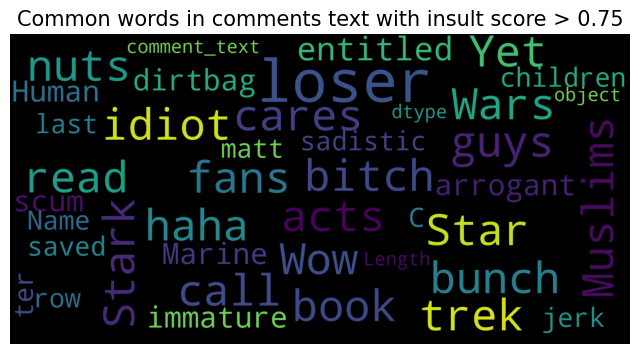

In [ ]:
# create word cloud of common words in comments with insult score >0.75 

w_cld = WordCloud(
        stopwords=stopwords,
        max_words=55,
        max_font_size=38, 
        scale=5,
        random_state=1
    ).generate(str(train_data.loc[train_data['insult'] > 0.75]['comment_text']))
 
# plot the wordcloud 
fig = plt.figure(1, figsize=(8,8))
plt.axis('off')
plt.title(label = 'Common words in comments text with insult score > 0.75', fontsize=15)
fig.subplots_adjust(top=2.3)
plt.imshow(w_cld)
plt.show()

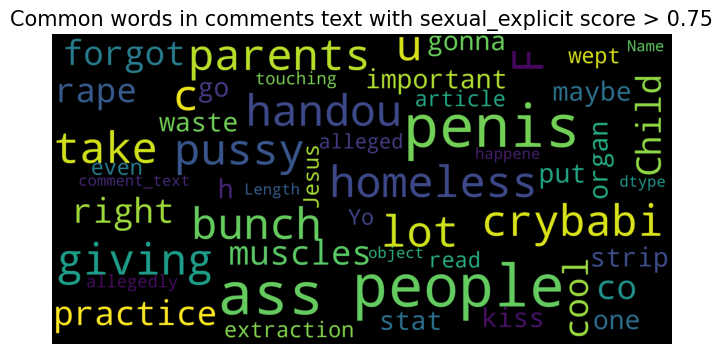

In [ ]:
# create word cloud of common words in comments with sexual_explicit score >0.75 
w_cld = WordCloud(
        stopwords=stopwords,
        max_words=55,
        max_font_size=38, 
        scale=5,
        random_state=1
    ).generate(str(train_data.loc[train_data['sexual_explicit'] > 0.75]['comment_text']))

# plot the word cloud
fig = plt.figure(1, figsize=(8,8))
plt.axis('off')
plt.title(label = 'Common words in comments text with sexual_explicit score > 0.75', fontsize=15)
fig.subplots_adjust(top=2.3)
plt.imshow(w_cld)
plt.show()

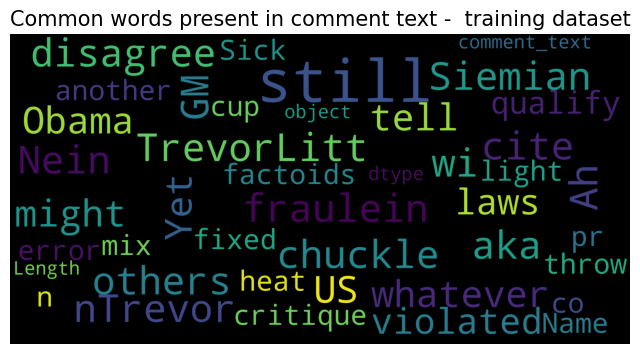

In [ ]:
# create word cloud of common words in comments from train data
w_cld = WordCloud(
        stopwords=stopwords,
        max_words=55,
        max_font_size=38, 
        scale=5,
        random_state=1
    ).generate(str(train_data['comment_text'].sample(19000)))

# plot the wordcloud
fig = plt.figure(1, figsize=(8,8))
plt.axis('off')
plt.title(label = 'Common words present in comment text -  training dataset', fontsize=15)
fig.subplots_adjust(top=2.3)
plt.imshow(w_cld)
plt.show()

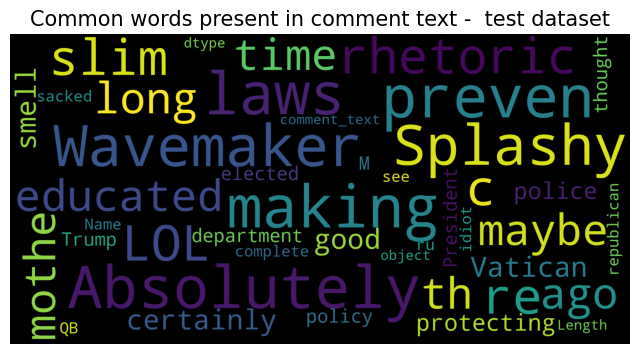

In [ ]:
# create word cloud of common words in comments from test data
w_cld = WordCloud(
        stopwords=stopwords,
        max_words=55,
        max_font_size=38, 
        scale=5,
        random_state=1
    ).generate(str(test_data['comment_text'].sample(19000)))

# plot the wordcloud
fig = plt.figure(1, figsize=(8,8))
plt.axis('off')
plt.title(label = 'Common words present in comment text -  test dataset', fontsize=15)
fig.subplots_adjust(top=2.3)
plt.imshow(w_cld)
plt.show()

### Distribution Plots

<ipython-input-23-4dd1be941e95>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_data['target'],kde=True,hist=False, bins=100, label='Toxicity')


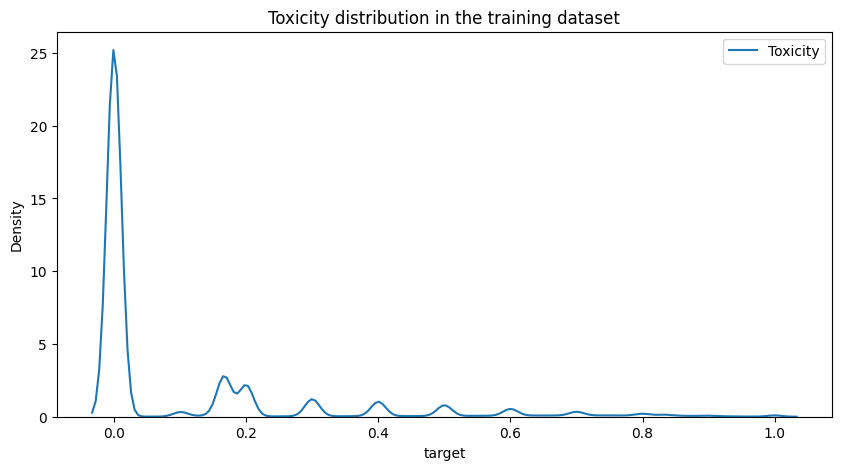

In [ ]:
# plot the distribution of Toxicity in train data
plt.figure(figsize=(10,5))
plt.title("Toxicity distribution in the training dataset")
sns.distplot(train_data['target'],kde=True,hist=False, bins=100, label='Toxicity')
plt.legend()
plt.show()

<ipython-input-24-cacc2101f67c>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Output_test,kde=True,hist=False, bins=100, label='Toxicity')


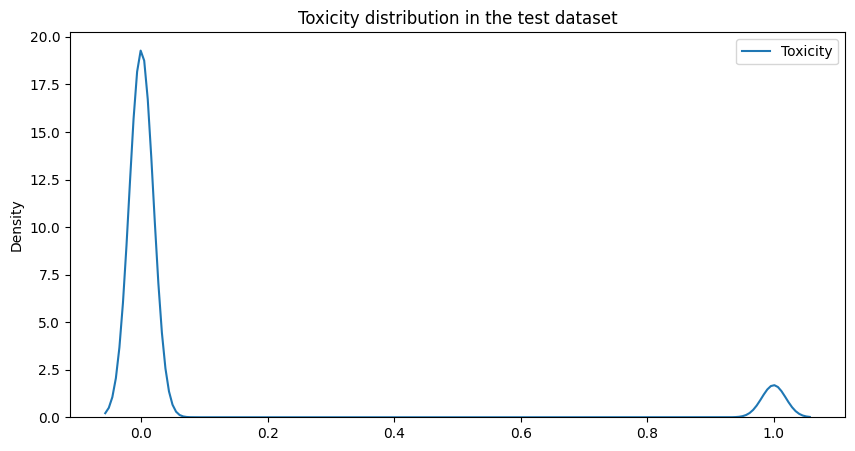

In [ ]:
# plot the distribution of Toxicity in test data
plt.figure(figsize=(10,5))
plt.title("Toxicity distribution in the test dataset")
sns.distplot(Output_test,kde=True,hist=False, bins=100, label='Toxicity')
plt.legend()
plt.show()

## SVM Modeling

In [ ]:
# create a svm model with support vector classifier using linear kernal 
Svm_model = SVC(kernel = "linear", verbose = False, max_iter = 20, probability = True)
# train the model using training data
Svm_model.fit(Input_train, Output_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(kernel='linear', max_iter=20, probability=True)

###Cross Validation

In [ ]:
# Calculate accuracy using cross validation score around 5 folds of training data
CrossVal_Acc = cross_val_score(Svm_model, Input_train, Output_train, cv=5, scoring='roc_auc',n_jobs = -1)
print("First fold accuracy  : ",CrossVal_Acc[0])
print("Second fold accuracy : ",CrossVal_Acc[1])
print("Third fold accuracy  : ",CrossVal_Acc[2])
print("Fourth fold accuracy : ",CrossVal_Acc[3])
print("Fifth fold accuracy  : ",CrossVal_Acc[4])
# Calculate mean of all cross validation accuracies
Svm_CrossVal_Acc = CrossVal_Acc.mean()
print("Mean of all Cross Validation Accuracies (ROC-AUC) : ",Svm_CrossVal_Acc)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


First fold accuracy  :  0.526379791398122
Second fold accuracy :  0.5320811688292859
Third fold accuracy  :  0.5164952509216987
Fourth fold accuracy :  0.5661751627035032
Fifth fold accuracy  :  0.48215826260970074
Mean of all Cross Validation Accuracies (ROC-AUC) :  0.5246579272924621


In [ ]:
# Calculate F1 Score using cross validation score around 5 folds of training data
CrossVal_F1 = cross_val_score(Svm_model, Input_train, Output_train, cv=5, scoring='f1_weighted',n_jobs = -1)
print("First fold F1  : ",CrossVal_F1[0])
print("Second fold F1 : ",CrossVal_F1[1])
print("Third fold F1  : ",CrossVal_F1[2])
print("Fourth fold F1 : ",CrossVal_F1[3])
print("Fifth fold F1  : ",CrossVal_F1[4])
# Calculate mean of all cross validation F1 scores
Svm_CrossVal_F1 = CrossVal_F1.mean()
print("Mean of all Cross Valication F1 Scores : ",Svm_CrossVal_F1)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


First fold F1  :  0.8275859778224699
Second fold F1 :  0.23515618732097812
Third fold F1  :  0.8792283219014615
Fourth fold F1 :  0.8400941962619184
Fifth fold F1  :  0.8435049777102235
Mean of all Cross Valication F1 Scores :  0.7251139322034102


###Testing

In [ ]:
# predict the target values for test data
Output_pred = Svm_model.predict(Input_test)

##Results

In [ ]:
# calculate accuracy of the test data
Svm_Acc = accuracy_score(Output_test, Output_pred)
print("SVM accuracy is :", Svm_Acc)

SVM accuracy is : 0.9192021608144608


Confusion Matrix
 [[552777    436]
 [ 48174    238]]


Text(104.7222222222223, 0.5, 'Original values')

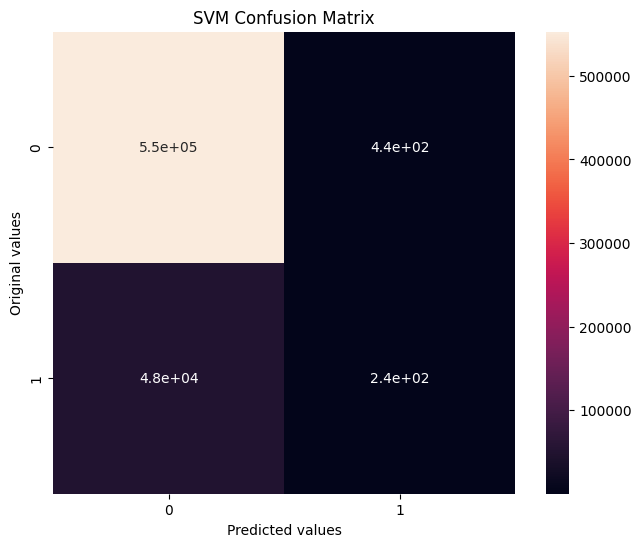

In [ ]:
# plot confusion matrix of the actual and predicted values
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(Output_test, Output_pred)
# print the confusion matrix
print('Confusion Matrix\n',conf_mat)
plt.title("SVM Confusion Matrix")
sns.heatmap(conf_mat, square=True, annot=True)
plt.xlabel('Predicted values')
plt.ylabel('Original values')

In [ ]:
# Print the classification report for test data 
print("SVM Classification Report")
# which includes accuracy, precision, recall, and f1-score
print(classification_report(Output_test, Output_pred))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    553213
           1       0.35      0.00      0.01     48412

    accuracy                           0.92    601625
   macro avg       0.64      0.50      0.48    601625
weighted avg       0.87      0.92      0.88    601625



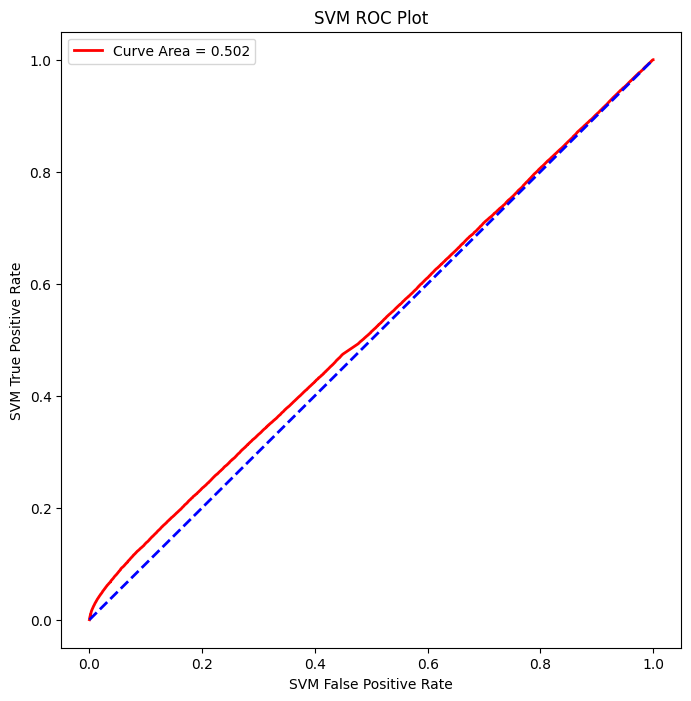

In [ ]:
# plot the graph of ROC(Receiver Operating Characteristic) for test data
# calculate fpr and trp using roc_curve
svm_fpr, svm_tpr, svm_thr = roc_curve(Output_test, Svm_model.predict_proba(Input_test)[:,1])
# calculate AUC(Area Under the Curve) using roc_auc_score of test data
svm_auc = roc_auc_score(Output_test, Output_pred)
plt.figure(figsize=(8, 8))
plt.plot(svm_fpr, svm_tpr, color='red', lw=2, label="Curve Area = %0.3f" % svm_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('SVM False Positive Rate')
plt.ylabel('SVM True Positive Rate')
plt.title('SVM ROC Plot')
plt.legend(loc="upper left")
plt.show()